In [22]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table, vstack
from cgmsquared import load_cgmsquared
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import casbah.gal_properties as caprop
import haloclustering.data as datamodule
import cgmsquared.clustering2 as c2
import pickle
import os
from astropy.cosmology import Planck15 as cosmo
import pandas as pd
import glob



plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
noncompact_df = pd.read_csv("/Users/mwilde/Downloads/cgm2_casbah_velo_split_table.csv")
noncompact_df['log_rho'] = np.log10(noncompact_df.rho)

In [24]:
# add masses to this table: pull out names from cgm2 and casbah data

In [25]:
casbahfile = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
survey_files = glob.glob(casbahfile)
cas_tab_list = []
for cas_tab_file in survey_files:
    tab = Table.read(cas_tab_file)
    # add in useful naming conventions
    # rho_impact in physical kpc
    tab["rho_rvir"] = tab["rho_impact"] / tab["rvir"]
    tab["rho"] = tab["rho_impact"]  # for hits_and_misses()
    tab["z"] = tab["z_1"]
    tab["sig_logN_HI"] = tab["sig_logN"]
    cas_tab_list.append(tab)

cgm_data_cas = vstack(cas_tab_list)
cgm_data_cas.remove_columns(['sig_logN', 'sig_logN_HI'])
cas_df = cgm_data_cas.to_pandas()
cas_df.cgm_name = cas_df['cgm_name'].str.decode('utf8')
cas_df = cas_df[['cgm_name', 'mstars', 'z']].drop_duplicates(subset='cgm_name')
cas_df = cas_df.set_index("cgm_name").sort_index()


In [26]:
cas_mask = noncompact_df.user == 'jnburchett'
cas_names = noncompact_df.loc[cas_mask, 'Name']
cas_names = cas_names.loc[cas_names.isin(cas_df.index.values)]
noncompact_df['mstars'].loc[cas_names.index] = 10**cas_df.loc[cas_names.values].mstars.values

/Users/mwilde/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [30]:
noncompact_df.to_csv('/Users/mwilde/python/haloclustering/haloclustering/data/combined_df.csv', index=False)

In [7]:
from cgmsquared import clustering as cgm2_cluster

r0, gamma, c0, alpha = np.array([ 3.83936011,  1.26462759, 32.7259534 ,  0.19868885])

rho_com = np.geomspace(0.001, 20, 100)
rho_com = noncompact_df.rho.sort_values().values/1000

z = 0.3
Hz = cosmo.H(z).value
dndz_index = 18
dndz_coeff = 1.5
chi_i_0_500 = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, 500.)
chi_i_0_400 = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, 400.)
chi_i_0_300 = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, 300.)
chi_i_0_200 = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, 200.)
chi_i_0_100 = c2.chi_perp_analytic(r0, gamma, rho_com, z, Hz, 100.)
chi_400_500 = (chi_i_0_500*500 - chi_i_0_400*400)/100
chi_200_300 = (chi_i_0_300*300 - chi_i_0_200*200)/100

def mean_dNdz(vmax=500.0):
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(
        z, danforth=False, kim=True) #, gamma=dndz_index, coeff=dndz_coeff
    clight = 299792.458
    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    return mean_dN_dz


mean_dNdz_0_100 = mean_dNdz(vmax=100)

def cov_frac(chi_perp, mean_dNdz):
    rate_of_incidence = (1 + chi_perp) * mean_dNdz
    prob_miss = np.exp(-rate_of_incidence)
    prob_hit = 1 - prob_miss
    return prob_hit

In [8]:
cf_400_500 = cov_frac(chi_400_500, mean_dNdz_0_100)
cf_200_300 = cov_frac(chi_200_300, mean_dNdz_0_100)
cf_0_100 = cov_frac(chi_i_0_100, mean_dNdz_0_100)
cf_0_500 = cov_frac(chi_i_0_500, mean_dNdz_0_100*5)

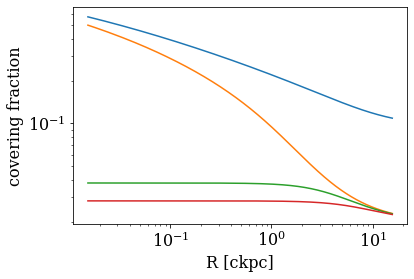

In [9]:
# plt.close('all')
plt.plot(rho_com, cf_0_500)
plt.plot(rho_com, cf_0_100)
plt.plot(rho_com, cf_200_300)
plt.plot(rho_com, cf_400_500)
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"R [ckpc]")
plt.ylabel(r"covering fraction");
# plt.ylim(0, 1)

In [10]:

def model_v_emp_plot(ax, df, bins, masslabel=None):

    colors = ['tab:blue', 'tab:purple', 'tab:pink']
    labels = ['0-100 km/s', '200-300 km/s', '400-500 km/s']
    cf_types = ['HM_0_100', 'HM_200_300', 'HM_400_500']
    for cf_type, color, label in zip(cf_types, colors, labels):
        
        active_df = df.query(f'{cf_type} != "inconclusive"').copy()
        active_df['response'] = active_df[cf_type] == 'hit'
        
        sns.regplot(data=active_df, x='rho', y='response', fit_reg=False, x_bins=bins, x_ci=68, ci=68,
                order=3, ax=ax, color=color, label=label);

    # plt.xlim(2, 4.2)
    # plt.close('all')
    if False:
        sns.regplot(x=rho_com*1000, y=cf_0_100, fit_reg=False, x_bins=bins, x_ci=68, ci=68,
                    order=3, ax=ax, color='C0', marker='D');
        sns.regplot(x=rho_com*1000, y=cf_200_300, fit_reg=False, x_bins=bins, x_ci=68, ci=68,
                    order=3, ax=ax, color='C1', marker='D');
        sns.regplot(x=rho_com*1000, y=cf_400_500, fit_reg=False, x_bins=bins, x_ci=68, ci=68,
                    order=3, ax=ax, color='C2', marker='D');
    # plt.plot(rho_com*1000, cf_0_500)
    ax.plot(rho_com*1000, cf_0_100, c=colors[0])
    ax.plot(rho_com*1000, cf_200_300, c=colors[1])
    ax.plot(rho_com*1000, cf_400_500, c=colors[2])

    if masslabel is not None:
        ax.text(0.3, 0.9, masslabel, transform=ax.transAxes)

    ax.set_yscale('log');
    ax.set_xscale('log');
    return ax



Text(0, 0.5, '$f_c$')

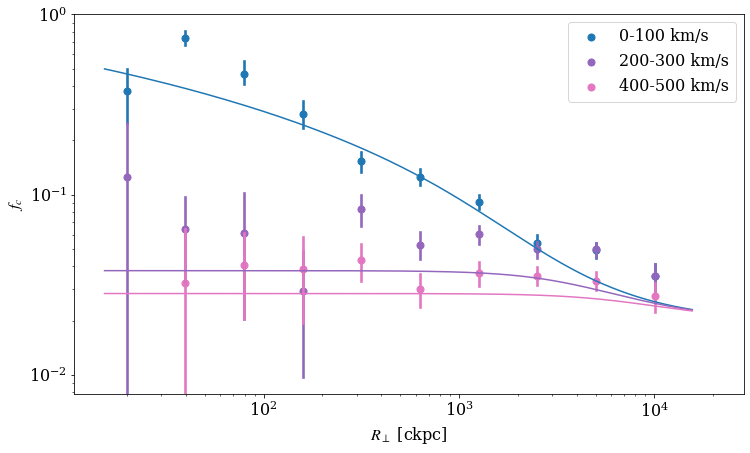

In [11]:
bins = np.concatenate([[10, 200, 400], np.geomspace(500, 18000, 10)])
bins = np.geomspace(10, 20000, 12)
fig, ax = plt.subplots(figsize=(12, 7))
ax = model_v_emp_plot(ax, noncompact_df, bins)
plt.legend()
plt.xlabel(r"$R_{\perp}$ [ckpc]")
plt.ylabel(r"$f_c$")

In [17]:
lomass_df = noncompact_df.query('1e7 < mstars < 2e9')
midmass_df = noncompact_df.query('2e9 < mstars < 9e9')
himass_df = noncompact_df.query('mstars > 9e9')



In [18]:
np.log10(2e9), np.log10(9e9)

(9.301029995663981, 9.954242509439325)

Text(0, 0.5, '$f_c$')

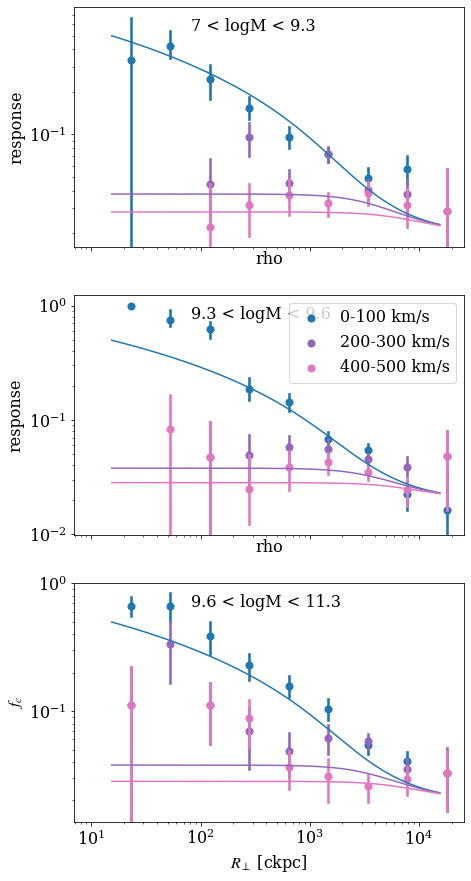

In [19]:
bins = np.geomspace(10, 18000, 10)
fig, axes = plt.subplots(nrows=3, sharex=True, figsize=(7, 15))
masslist = [r'7 < logM < 9.3', '9.3 < logM < 9.6', '9.6 < logM < 11.3']
for ax, df, masslabel in zip(axes, [lomass_df, midmass_df, himass_df], masslist):
    ax = model_v_emp_plot(ax, df, bins, masslabel=masslabel)
fig.subplots_adjust()
axes[1].legend()
plt.xlabel(r"$R_{\perp}$ [ckpc]")
plt.ylabel(r"$f_c$")

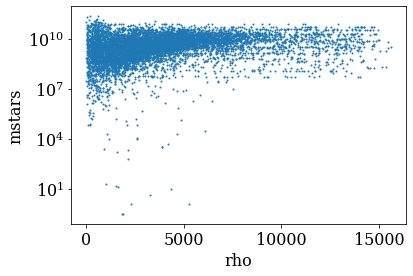

In [20]:
noncompact_df.plot(kind='scatter', x='rho', y='mstars',s=1)
plt.yscale('log')

In [21]:
cas_df.mstars.max()

12.421270986691475